# Image transformers

dwgfystrmrodv4o6ql7vzfov1

```python
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

# # Load model and processor
model = AutoModelForCausalLM.from_pretrained("microsoft/Magma-8B", trust_remote_code=True).to("mps")
processor = AutoProcessor.from_pretrained("microsoft/Magma-8B", trust_remote_code=True)

model = model.to(dtype=torch.float32, device="mps")

# Load image
image = Image.open("../images/image.png").convert("RGB")

# Setup prompt
convs = [
    {"role": "system", "content": "You are agent that can see, talk and act."},
    {"role": "user", "content": "<image_start><image><image_end>\nWhat is in this image?"},
]
prompt = processor.tokenizer.apply_chat_template(convs, tokenize=False, add_generation_prompt=True)

# Preprocess inputs
inputs = processor(images=image, texts=prompt, return_tensors="pt")
inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)
inputs["image_sizes"] = inputs["image_sizes"].unsqueeze(0)

# Move to MPS with consistent dtype
# Get model dtype from its embedding layer
model_dtype = model.get_input_embeddings().weight.dtype

# Move inputs to MPS with correct dtype handling
for k, v in inputs.items():
    if isinstance(v, torch.Tensor):
        if v.dtype in [torch.float32, torch.float64, torch.float16, torch.bfloat16]:
            # Cast float tensors to match model (likely bfloat16 on MPS)
            inputs[k] = v.to(dtype=model_dtype, device="mps")
        else:
            inputs[k] = v.to("mps")

# Generation arguments
generation_args = {"max_new_tokens": 50, "do_sample": False}

# Generate
with torch.inference_mode():
    generate_ids = model.generate(**inputs, **generation_args)

generate_ids = generate_ids[:, inputs["input_ids"].shape[-1] :]
response = processor.decode(generate_ids[0], skip_special_tokens=True).strip()
print(response)
```

`RuntimeError: MPS backend out of memory (MPS allocated: 18.48 GB, other allocations: 6.33 MB, max allowed: 20.40 GB). Tried to allocate 1.96 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).`

## Image-to-text match

In [27]:
from dataclasses import dataclass


@dataclass
class CustomConfig:
    model_name: str = "google/vit-base-patch16-224"
    image_path: str = "../images/image.png"
    device: str = "mps"

In [ ]:
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

CONFIG = CustomConfig(
    model_name="openai/clip-vit-base-patch32",
    image_path="/Users/deburky/Documents/SORA/1200_6004226682682c539dc06eff.jpg",
    device="mps",
)

model = CLIPModel.from_pretrained(CONFIG.model_name).to(CONFIG.device)
processor = CLIPProcessor.from_pretrained(CONFIG.model_name)

image = Image.open(CONFIG.image_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(CONFIG.device)

with torch.no_grad():
    image_features = model.get_image_features(**inputs)

# Normalize the embeddings (important for cosine similarity)
image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

print("Image embedding:", image_features.shape)

texts = ["a cat", "a person", "a dog", "a keyboard, a mouse", "a car", "a tree", "a house"]
text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(CONFIG.device)

with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

# Compute similarity
similarity = torch.matmul(image_features, text_features.T)
best_match = torch.argmax(similarity).item()

print("Best match:", texts[best_match])

Image embedding: torch.Size([1, 512])


## OCR

In [95]:
from PIL import Image, ImageDraw, ImageFont

text = "The quick lazy fox jumps over the obscure dog"
image = Image.new("RGB", (2000, 150), color="white")
draw = ImageDraw.Draw(image)

# Load a real font
font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", 70)
draw.text((10, 50), text, font=font, fill="black")
image.save("../images/test_text.png")

image = Image.open("../images/test_text.png").convert("RGB")
inputs = processor(images=image, return_tensors="pt").to("mps")
with torch.no_grad():
    output = model.generate(**inputs)
    print(processor.decode(output[0], skip_special_tokens=True))

THE QUICK LAZY FOR JUMPS OVER THE OBSCURE DOG -


In [ ]:
import easyocr

reader = easyocr.Reader(["en"], gpu=False)
result = reader.readtext("../images/test_text.png", detail=0)
print(result)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

INFO:easyocr.easyocr:Download complete


Progress: |██████████████████████████████████----------------| 69.8% Complete

INFO:easyocr.easyocr:Download complete.


Progress: |██████████████████████████████████████████████████| 100.0% Complete['The quick lazy fox jumps over the obscure', 'dog']


## OCR 2

In [40]:
from dataclasses import dataclass

import torch
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


@dataclass
class CustomConfig:
    model_name: str = "microsoft/trocr-base-printed"
    image_path: str = "../images/test_text.png"
    device: str = "mps"


CONFIG = CustomConfig()

# Load model and processor
processor = TrOCRProcessor.from_pretrained(CONFIG.model_name)
model = VisionEncoderDecoderModel.from_pretrained(CONFIG.model_name).to(CONFIG.device)

# Load and preprocess image
image = Image.open(CONFIG.image_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(CONFIG.device)

# Run inference
with torch.no_grad():
    generated_ids = model.generate(**inputs)
    decoded_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("OCR Result:", decoded_text)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

OCR Result: EXCEIPT(RM)***


dwgfystrmrodv4o6ql7vzfov1

## ViT

/Users/deburky/Documents/python/llm-rag/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


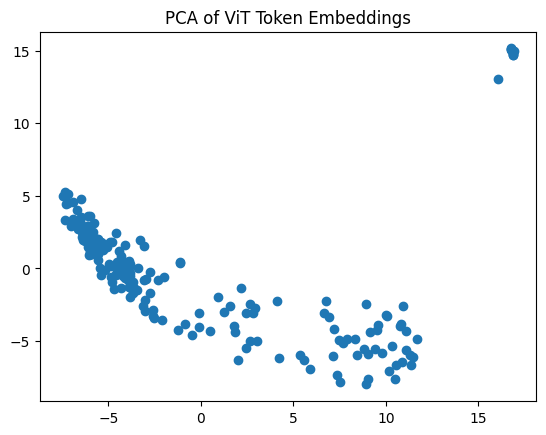

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel

# Load model
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load image
image = Image.open("../images/image.png").convert("RGB")
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Extract token embeddings (shape: [1, num_tokens, hidden_size])
tokens = outputs.last_hidden_state.squeeze(0).detach().numpy()  # shape: (197, 768)

# Apply PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(tokens)

# Plot
plt.scatter(proj[:, 0], proj[:, 1])
plt.title("PCA of ViT Token Embeddings")
plt.show()

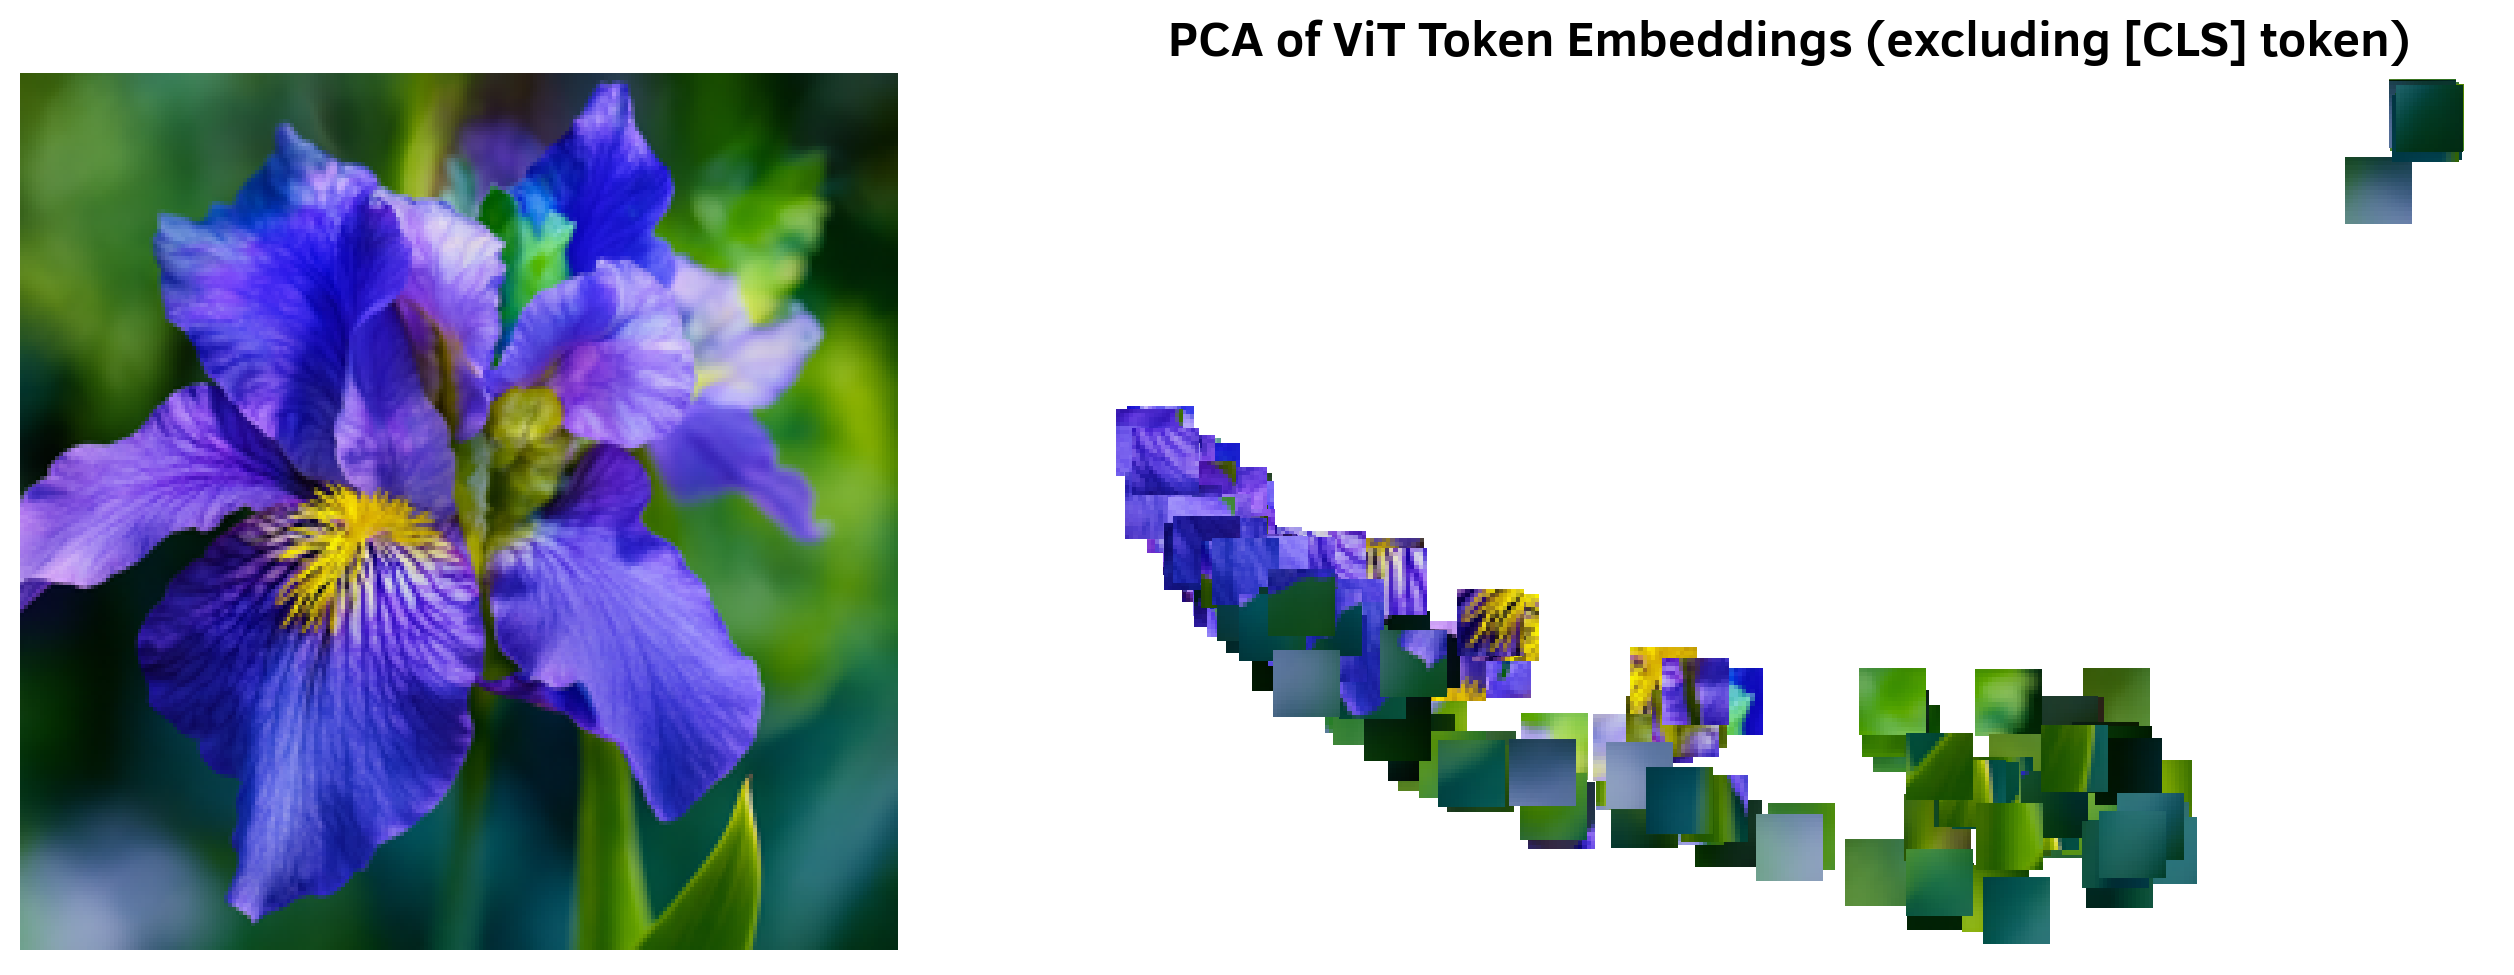

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Set font to 'comic shanns'
plt.rcParams["font.family"] = "Clear Sans"

# Exclude [CLS] token from projection
patch_proj = proj[1:]  # shape: (196, 2)
coords = [(i // 14, i % 14) for i in range(196)]

image_resized = image.resize((224, 224))  # Ensure it's 224×224 to match ViT input
patch_size = 16
grid_size = 14

# 🌈
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# add original image
ax1.imshow(image_resized)
# ax2.set_title("Original Image", fontdict={"size": 18, "weight": "bold"})
ax1.set_xticks([])
ax1.set_yticks([])

ax2.set_title(
    "PCA of ViT Token Embeddings (excluding [CLS] token)",
    fontdict={"size": 18, "weight": "bold"},
)
ax2.scatter(patch_proj[:, 0], patch_proj[:, 1], c="lightgray", alpha=0.6)

# ----- Add image patches to scatter -----
for idx in range(len(patch_proj)):  # [0, 12, 45, 100, 150]:
    row, col = coords[idx]
    x = col * patch_size
    y = row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))

    # Embed into PCA plot
    imagebox = OffsetImage(patch, zoom=1.5)
    ab = AnnotationBbox(imagebox, (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False)
    ax2.add_artist(ab)

ax1.axis("off")
ax2.axis("off")
plt.tight_layout()
plt.show()

## Attention

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


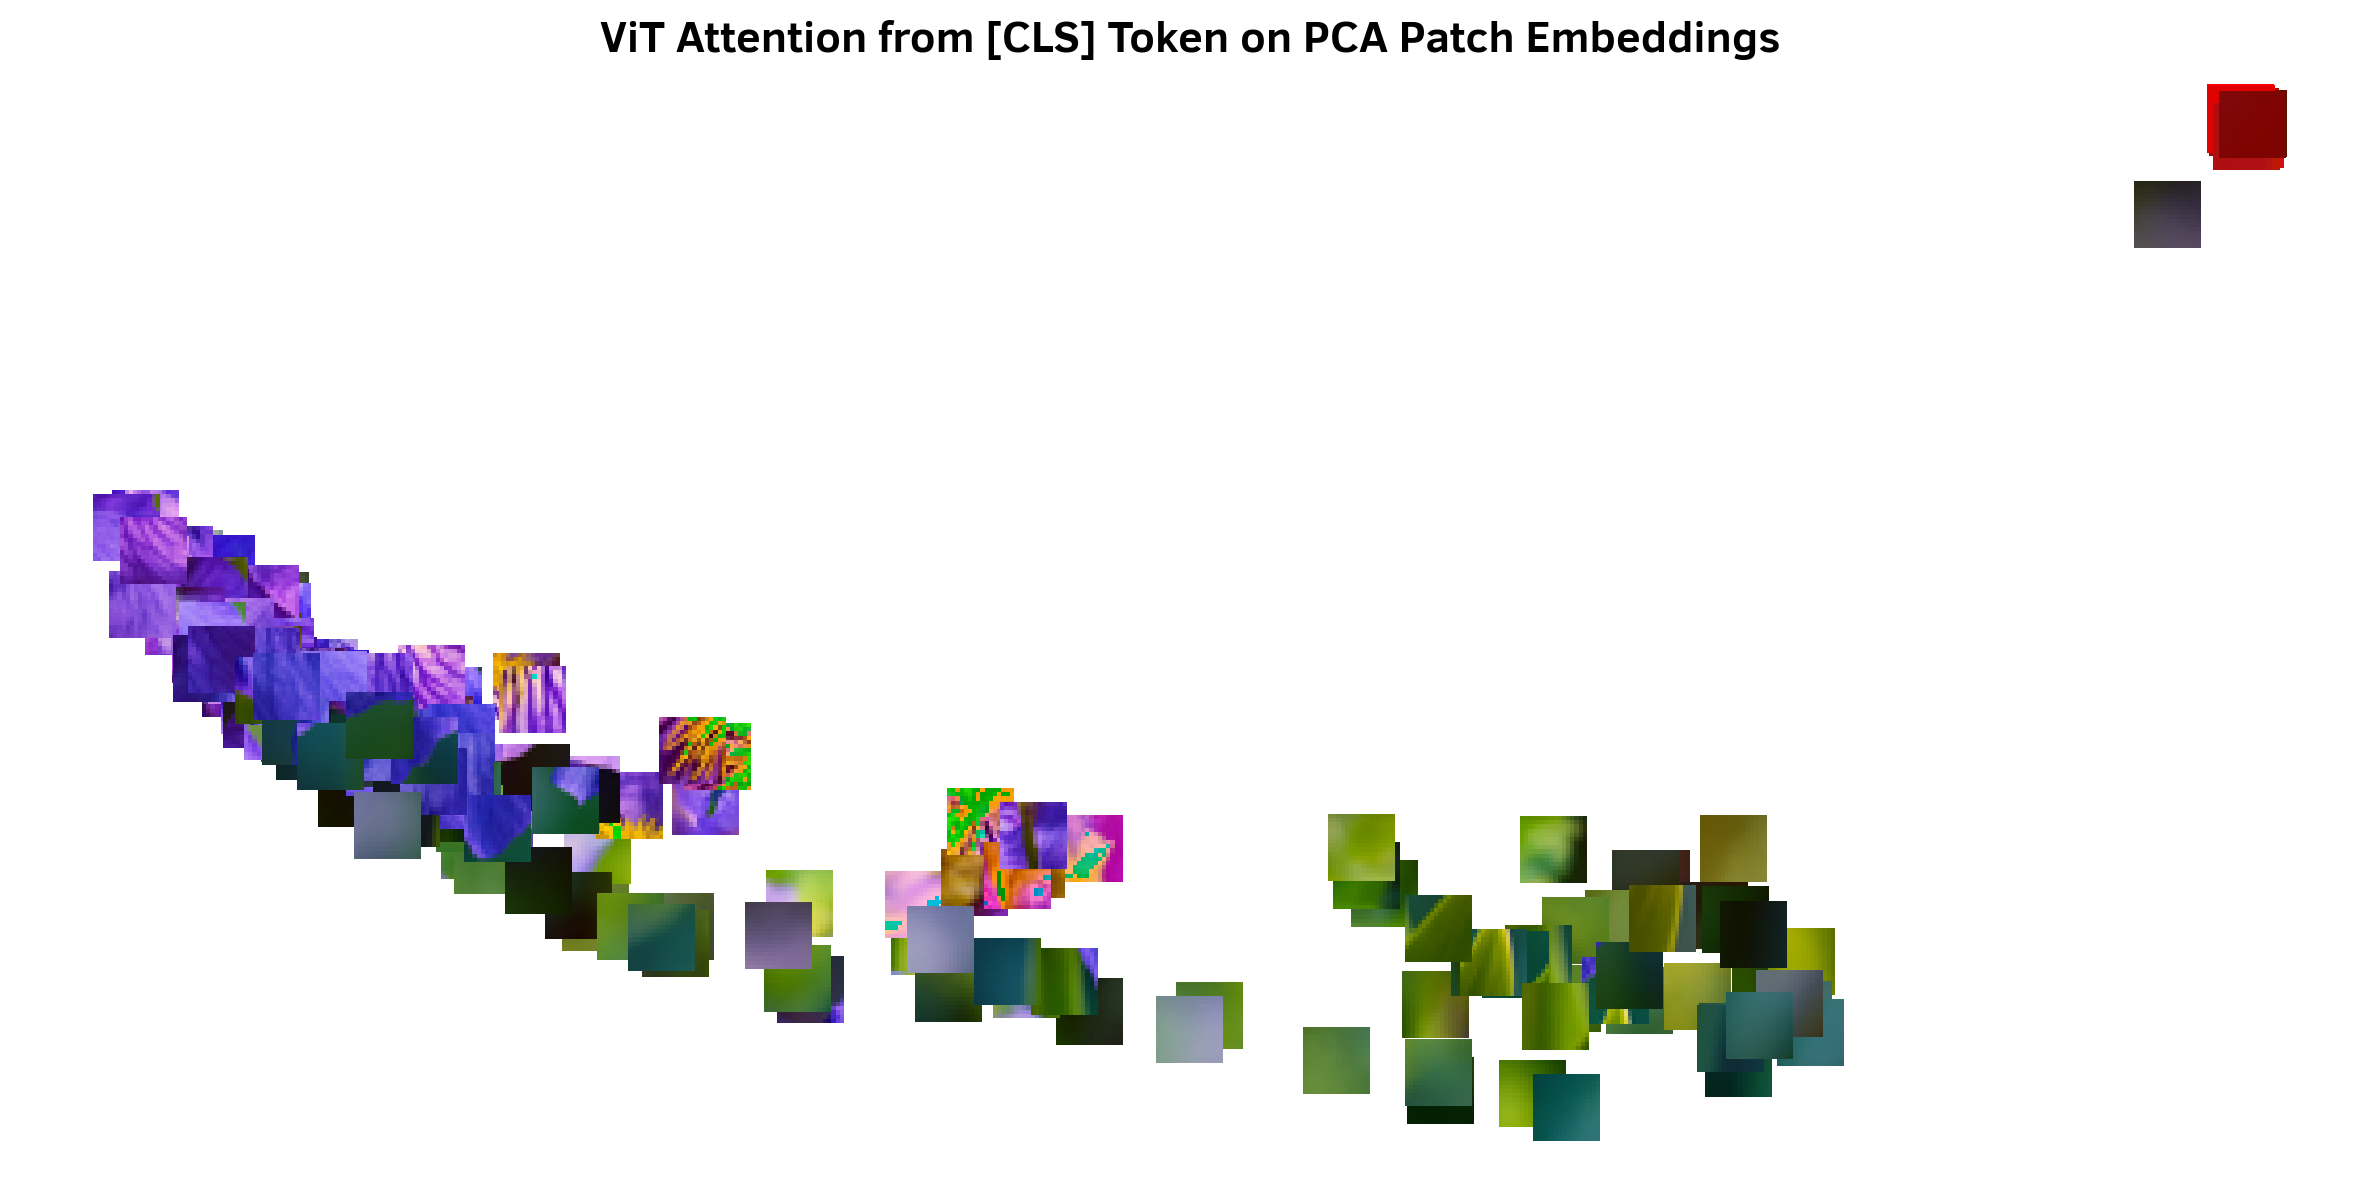

In [ ]:
import torch
from PIL import Image
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel

# --- Configuration ---
IMAGE_PATH = "../images/image.png"
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load image and model ---
image = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()

# --- Preprocess and run forward pass ---
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

# --- Extract token embeddings ---
tokens = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # shape: (197, 768)

# --- PCA projection ---
proj = PCA(n_components=2).fit_transform(tokens)
patch_proj = proj[1:]  # exclude [CLS]

# --- Extract attention from [CLS] token ---
attn = outputs.attentions[-1][0, :, 0, 1:]  # shape: (heads, 196)
attn_mean = attn.mean(0).cpu().numpy()  # shape: (196,)
attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min() + 1e-8)

# Image preparation
image_resized = image.resize((224, 224))  # Match ViT input
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(len(patch_proj))]

# 🎨 Plot
plt.rcParams["font.family"] = "Clear Sans"
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.set_title("ViT Attention from [CLS] Token on PCA Patch Embeddings", fontsize=16, weight="bold")
ax.scatter(patch_proj[:, 0], patch_proj[:, 1], c="lightgray", alpha=0.3)

# 🔥 Overlay attention-tinted patches
for idx in range(len(patch_proj)):
    row, col = coords[idx]
    x = col * patch_size
    y = row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))

    # Apply red tint based on attention weight
    patch_np = np.array(patch).astype(np.float32) / 255.0
    alpha = attn_norm[idx]  # [0, 1]
    red_overlay = np.array([5.0, 0.0, 0.0])
    tinted = (1 - alpha) * patch_np + alpha * red_overlay
    tinted_patch = Image.fromarray((tinted * 255).astype(np.uint8))

    imagebox = OffsetImage(tinted_patch, zoom=1.5)
    ab = AnnotationBbox(imagebox, (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis("off")
plt.tight_layout()
plt.show()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


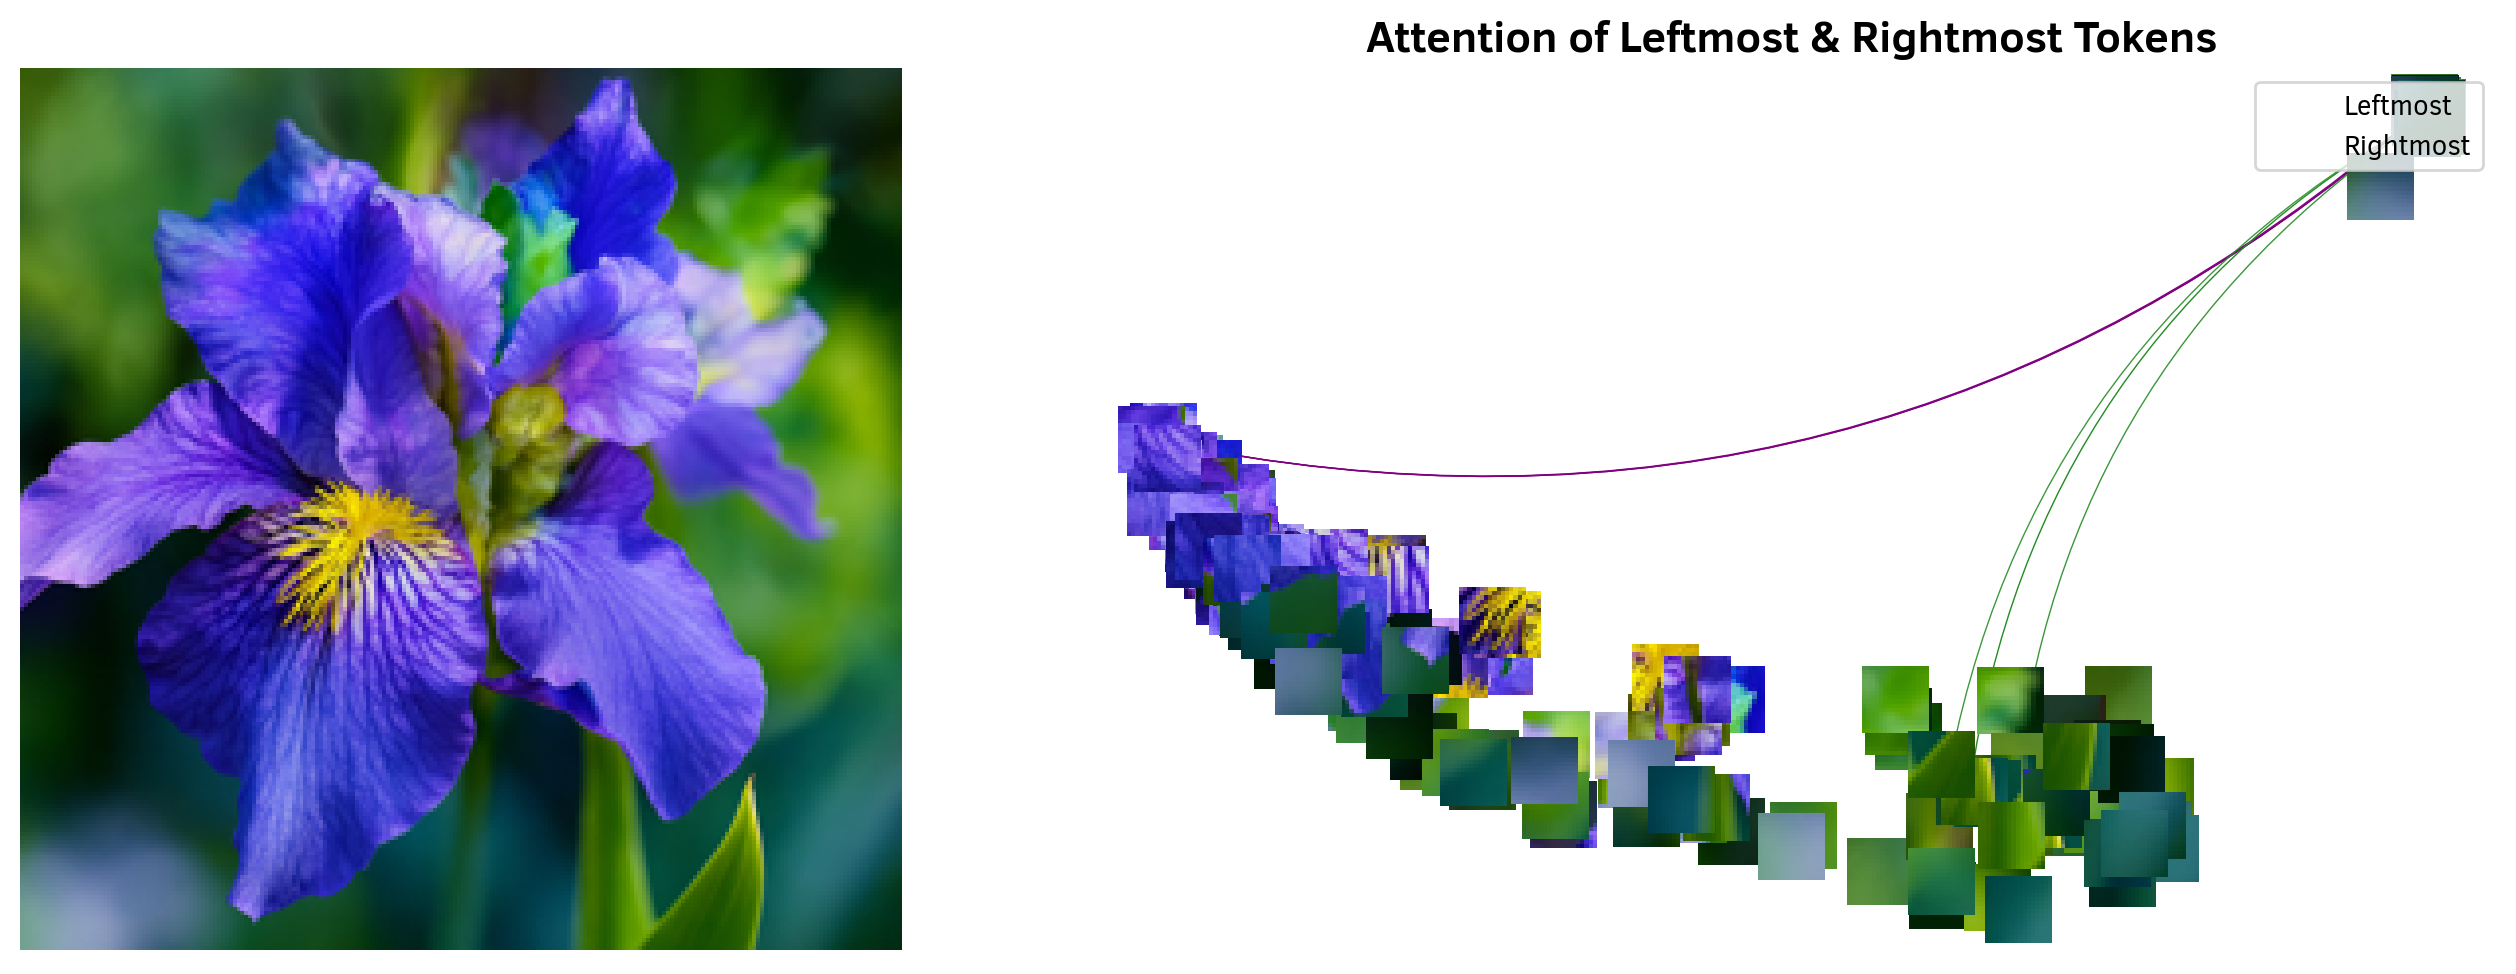

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.patches import FancyArrowPatch
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel

# --- Config ---
IMAGE_PATH = "../images/image.png"
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# --- Load image & model ---
image = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()

# --- Forward pass ---
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

# --- Embeddings & PCA ---
tokens = outputs.last_hidden_state.squeeze(0).cpu().numpy()
proj = PCA(n_components=2).fit_transform(tokens)
patch_proj = proj[1:]  # exclude [CLS]

# --- Patch info ---
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(len(patch_proj))]
image_resized = image.resize((224, 224))

# --- Plot ---
plt.rcParams["font.family"] = "Clear Sans"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

ax1.imshow(image_resized)
ax1.axis("off")

ax2.set_title("Attention of Leftmost & Rightmost Tokens", fontsize=16, weight="bold")
ax2.scatter(patch_proj[:, 0], patch_proj[:, 1], c="lightgray", alpha=0.6)

# Show patches
for idx in range(len(patch_proj)):
    row, col = coords[idx]
    x, y = col * patch_size, row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))
    ab = AnnotationBbox(
        OffsetImage(patch, zoom=1.5), (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False
    )
    ax2.add_artist(ab)


def draw_attention_from(src_idx, color="crimson", label=""):
    src_proj = patch_proj[src_idx]
    attn = outputs.attentions[-1][0, :, src_idx + 1, 1:]  # heads × 196
    attn_mean = attn.mean(0).cpu().numpy()
    attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min() + 1e-8)
    topk_idx = np.argsort(attn_mean)[-3:]

    # Arrows from src
    for idx in topk_idx:
        if idx == src_idx:
            continue
        dest = patch_proj[idx]
        arrow = FancyArrowPatch(
            posA=src_proj,
            posB=dest,
            arrowstyle="->",
            color=color,
            linewidth=0.5,
            alpha=attn_norm[idx],
            connectionstyle="arc3,rad=0.25",
        )
        ax2.add_artist(arrow)

    # Mark the source
    ax2.scatter(
        *src_proj,
        s=0,
        c=color,
        marker=None,
        edgecolors="black",
        linewidths=1.5,
        zorder=5,
        label=label,
    )


# --- Draw attention from two sources ---
left_idx = patch_proj[:, 0].argmin()
right_idx = patch_proj[:, 0].argmax()
draw_attention_from(left_idx, color="purple", label="Leftmost")
draw_attention_from(right_idx, color="forestgreen", label="Rightmost")

ax2.axis("off")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


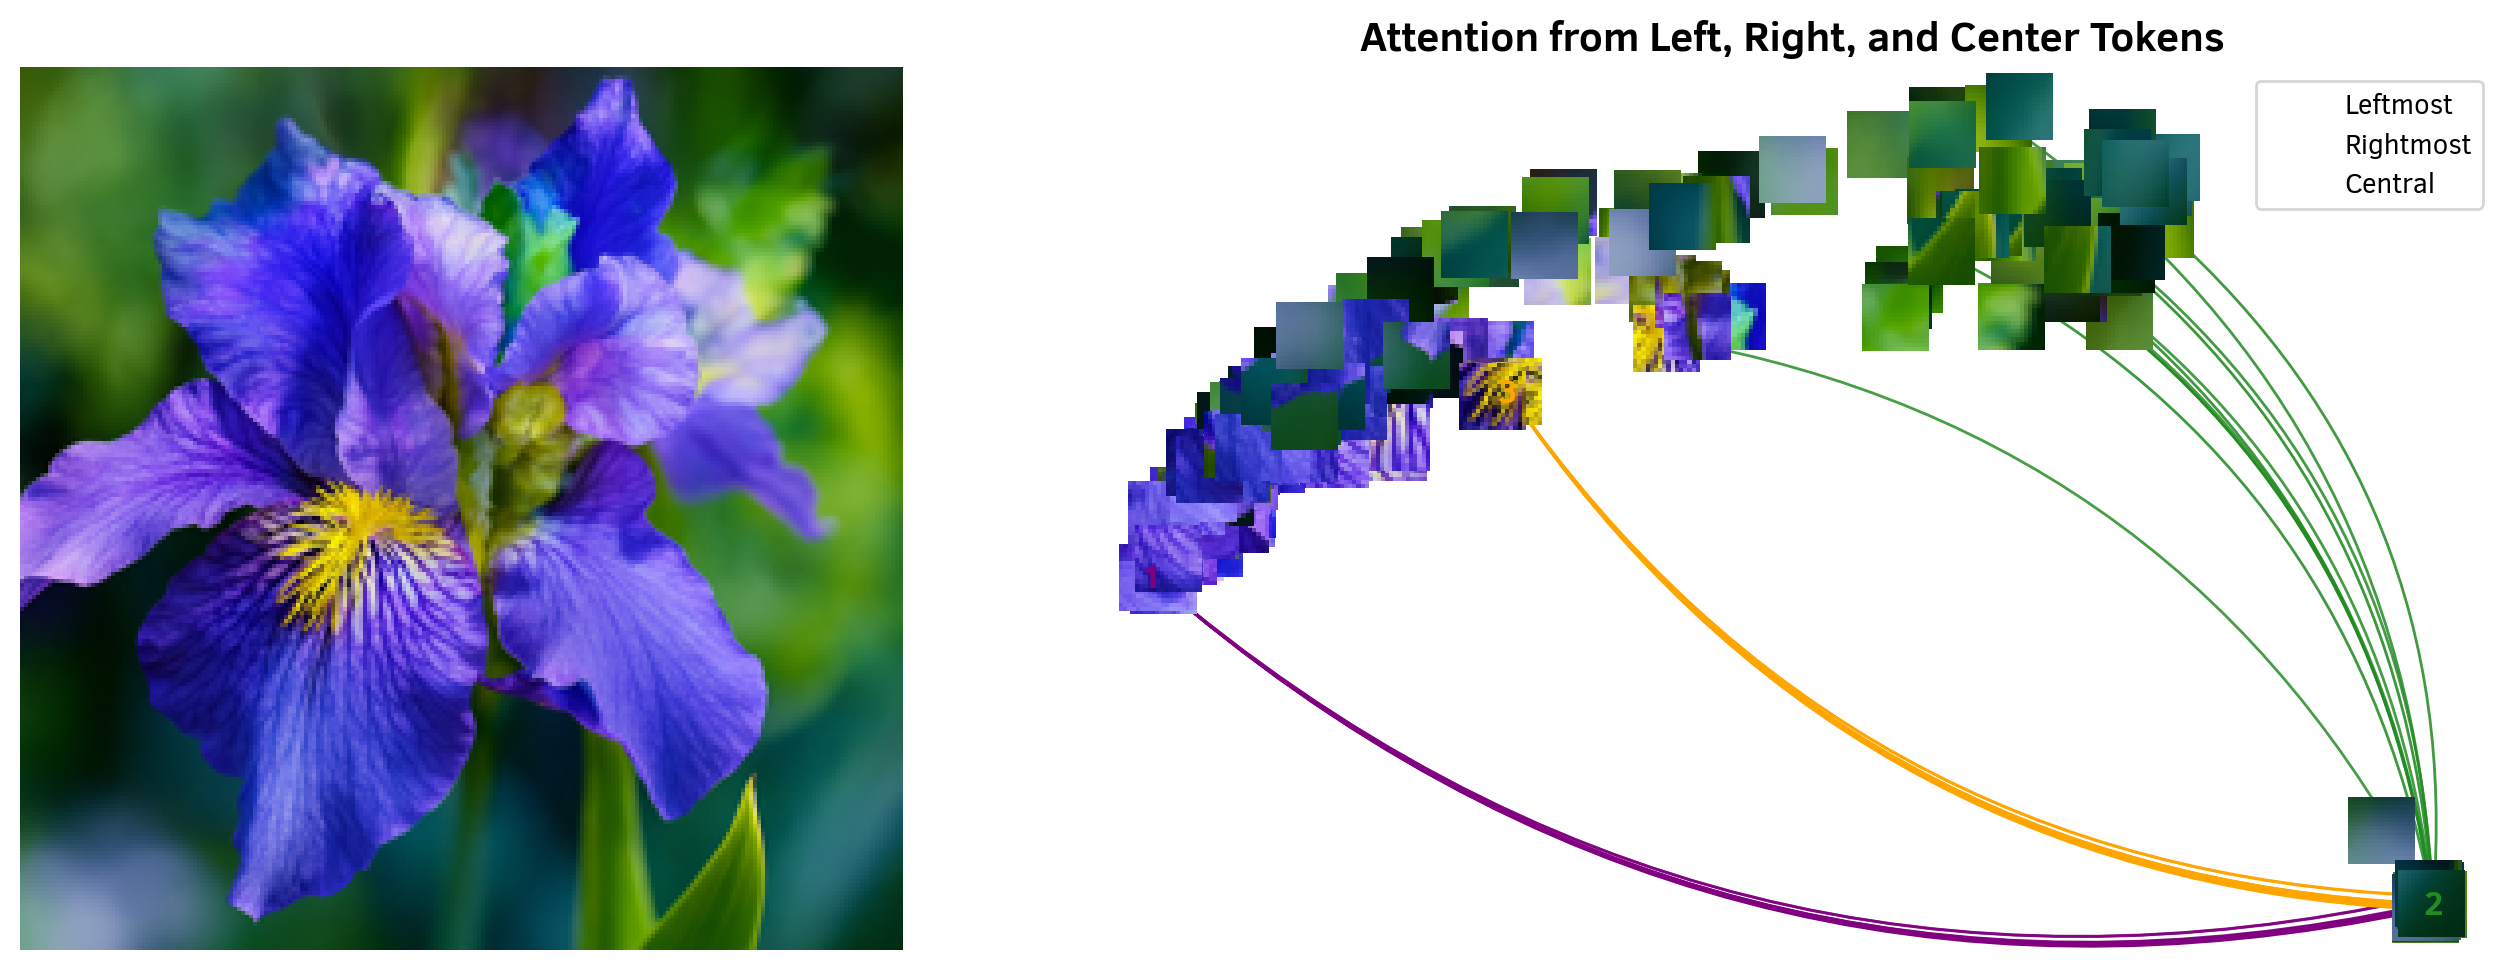

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel

# --- Config ---
IMAGE_PATH = "../images/image.png"
MODEL_NAME = "google/vit-base-patch16-224"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# --- Load image & model ---
image = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()

# --- Forward pass ---
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

# --- Embeddings & PCA ---
tokens = outputs.last_hidden_state.squeeze(0).cpu().numpy()
proj = PCA(n_components=2).fit_transform(tokens)
patch_proj = proj[1:]  # exclude [CLS]

# --- Patch info ---
patch_size = 16
grid_size = 14
coords = [(i // grid_size, i % grid_size) for i in range(len(patch_proj))]
image_resized = image.resize((224, 224))

# --- Plot ---
plt.rcParams["font.family"] = "Clear Sans"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

ax1.imshow(image_resized)
ax1.axis("off")

ax2.set_title("Attention from Left, Right, and Center Tokens", fontsize=15, weight="bold")
ax2.scatter(patch_proj[:, 0], patch_proj[:, 1], c="lightgray", alpha=0.6)

# Show patches
for idx in range(len(patch_proj)):
    row, col = coords[idx]
    x, y = col * patch_size, row * patch_size
    patch = image_resized.crop((x, y, x + patch_size, y + patch_size))
    ab = AnnotationBbox(
        OffsetImage(patch, zoom=1.5), (patch_proj[idx, 0], patch_proj[idx, 1]), frameon=False
    )
    ax2.add_artist(ab)


# --- Draw function ---
def draw_attention_from(src_idx, color="crimson", label="", top_k: int = 10, number=None):
    src_proj = patch_proj[src_idx]
    attn = outputs.attentions[-1][0, :, src_idx + 1, 1:]  # heads × 196
    attn_mean = attn.mean(0).cpu().numpy()
    attn_norm = (attn_mean - attn_mean.min()) / (attn_mean.max() - attn_mean.min() + 1e-8)
    topk_idx = np.argsort(attn_mean)[-top_k:]

    for idx in topk_idx:
        if idx == src_idx:
            continue
        dest = patch_proj[idx]
        arrow = FancyArrowPatch(
            posA=src_proj,
            posB=dest,
            arrowstyle="->",
            color=color,
            linewidth=1.0,
            alpha=attn_norm[idx],
            connectionstyle="arc3,rad=0.25",
        )
        ax2.add_artist(arrow)

    # Mark the source
    ax2.scatter(
        *src_proj,
        s=0,
        c=color,
        marker=None,
        edgecolors="black",
        linewidths=1.5,
        zorder=5,
        label=label,
    )
    if number is not None:
        ax2.text(
            src_proj[0],
            src_proj[1] + 0.5,
            str(number),
            fontsize=12,
            fontweight="bold",
            color=color,
            ha="center",
            va="bottom",
        )


# --- Select indices ---
left_idx = patch_proj[:, 0].argmin()
right_idx = patch_proj[:, 0].argmax()
center_idx = np.linalg.norm(patch_proj - patch_proj.mean(0), axis=1).argmin()

# --- Draw all three ---
draw_attention_from(left_idx, color="purple", label="Leftmost", number=1)
draw_attention_from(right_idx, color="forestgreen", label="Rightmost", number=2)
draw_attention_from(center_idx, color="orange", label="Central", number=3)

ax2.axis("off")
# turn ax2 upside down
ax2.invert_yaxis()
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()